In [ ]:
# hide
# all_tutorial

# Small Molecule Property Optimization - Multiparameter Optimization

>Small molecule MPO

## Multiparameter Optimization

This notebook shows how to optimize a generative model with respect to an MPO score consisting of multiple desired properties

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Agent

Here we create the model we want to optimize. We will use the `LSTM_LM_Small_ZINC_NC` - a LSTM-based language model pretrained on part of the ZINC database without chirality. Training without chirality prevents a form of mode collapse where the model converges to generating different isomers of the same compound.

Whether or not to use a model trained with or without chirality depends on the reward function you are trying to optimize. You should use a model with chirality if your reward function handles chirality in a meaningful way. Specically this means your reward function should give different scores to different isomers. This difference should relate to a real aspect of the propety predicted (ie affinity of different isomers) rather than being a spurious feature learned by the model (this happens surprisingly often).

Our score isn't influenced by chirality, so we will use a nonchiral model

In [ ]:
agent = LSTM_LM_Small_ZINC_NC(drop_scale=0.3, opt_kwargs={'lr':5e-5})

## Template


In [ ]:
def scale_sa(sa):
    return (10-sa)/9

def scale_logp(logp):
    logp = logp/5
    logp = min(max(logp,0),1)
    return logp

def scale_qed(qed):
    return 2*qed

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     MolWtFilter(None, 500),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     LogPFilter(None, 5)
                     ],
                    [QEDFilter(None, None, score=PropertyFunctionScore(scale_qed)),
                     SAFilter(None, None, score=PropertyFunctionScore(scale_sa)),
                     LogPFilter(None, None, score=PropertyFunctionScore(scale_logp))], 
                    fail_score=-1., log=False)

template_cb = TemplateCallback(template, prefilter=True)

## Reward

We are only optimizing towards Penaized LogP, which is contained in our template. For this reason, we don't have any additional score terms

## Loss Function

We will use the `PPO` policy gradient algorithm

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)

loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

## Samplers

We set up the following samplers:
- `sampler1`: samples from the main model
- `sampler2`: samples from the baseline model
- `sampler3`: samples high scoring compounds from the log

In [ ]:
gen_bs = 1500

sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 1000, 0., gen_bs)
sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)

samplers = [sampler1, sampler2, sampler3]

## Other Callbacks

We add the following callbacks:
- `supervised_cb`: every 200 batches, this callback grabs the top 3% of samples from the log and runs supervised training with these samples
- `live_max`: prints the maximum score from `sampler1` each batch
- `live_p90`: prints the top 10% score from `sampler1` each batch

In [ ]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

## Environment

We create our environment with the objects assembled so far

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[], losses=[loss],
                 cbs=cbs)

## Train

In [ ]:
set_global_pool(10)

In [ ]:
env.fit(200, 90, 2000, 40)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,PPO,rewards_live_p90,rewards_live_max
0,2.707,2.707,1.000,1.000,200,2.707,1.000,0.259,3.155,3.261
40,2.730,2.730,0.955,1.000,200,2.730,1.000,0.018,3.139,3.382
80,2.813,2.813,0.985,1.000,200,2.813,1.000,-0.009,3.231,3.499
120,2.829,2.829,0.955,1.000,200,2.829,1.000,-0.016,3.143,3.543
160,2.849,2.849,0.940,1.000,200,2.849,1.000,-0.015,3.231,3.401
200,2.854,2.854,0.970,1.000,200,2.854,1.000,-0.012,3.229,3.412
240,2.970,2.970,0.920,1.000,200,2.970,1.000,-0.010,3.329,3.541
280,2.898,2.898,0.975,1.000,200,2.898,1.000,-0.007,3.291,3.523
320,2.975,2.975,0.930,1.000,200,2.975,1.000,-0.012,3.387,3.529
360,2.986,2.986,0.930,1.000,200,2.986,1.000,-0.020,3.337,3.434


Epoch,Train Loss,Valid Loss,Time
0,0.35779,0.39156,00:05


Epoch,Train Loss,Valid Loss,Time
0,0.36184,0.37484,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.33163,0.34213,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.30147,0.31557,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.30350,0.27757,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.27284,0.29188,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.27972,0.25462,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.27231,0.25685,00:08


Epoch,Train Loss,Valid Loss,Time
0,0.28549,0.26994,00:08


Epoch,Train Loss,Valid Loss,Time
0,0.28928,0.27114,00:08


Process ForkPoolWorker-1218:
Process ForkPoolWorker-1222:
Process ForkPoolWorker-1220:
Process ForkPoolWorker-1215:
Traceback (most recent call last):
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
Traceback (most recent call last):
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self.

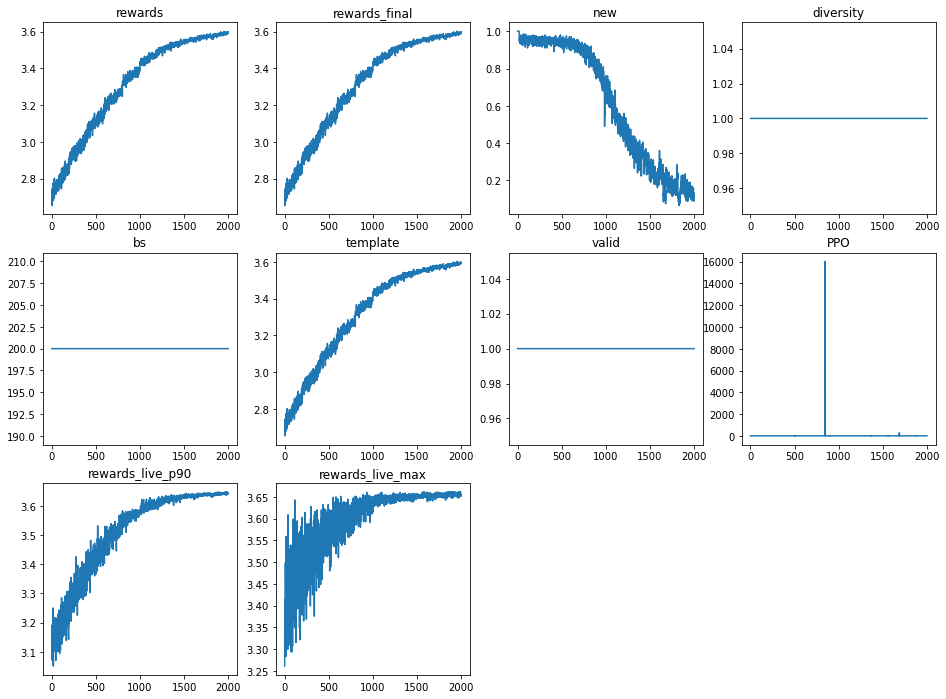

In [ ]:
env.log.plot_metrics()

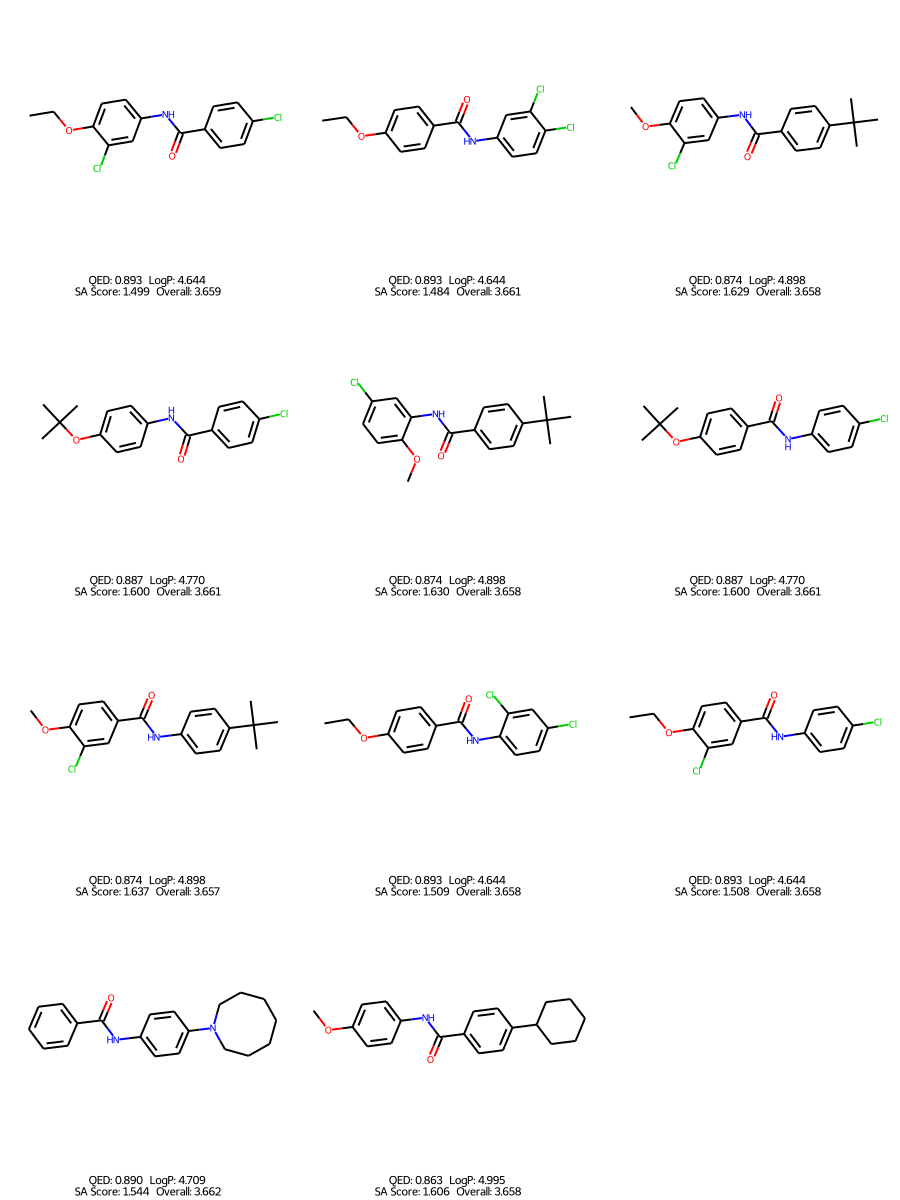

In [ ]:
subset = env.log.df[env.log.df.rewards>3.657]
samples = subset.samples.values
values = subset.rewards.values
mols = [to_mol(i) for i in samples]
qeds = [qed(i) for i in mols]
logps = [logp(i) for i in mols]
sas = [sa_score(i) for i in mols]

legends = [f'QED: {qeds[i]:.3f}\tLogP: {logps[i]:.3f}\nSA Score: {sas[i]:.3f}\tOverall: {values[i]:.3f}'
          for i in range(len(samples))]

draw_mols(mols, legends=legends)